# A5-Q4: Population Coding

# Prelims

In [273]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import robot

torch.set_grad_enabled(False)

## How to use the `Arm` class
Note that the `Arm` class uses NumPy arrays.

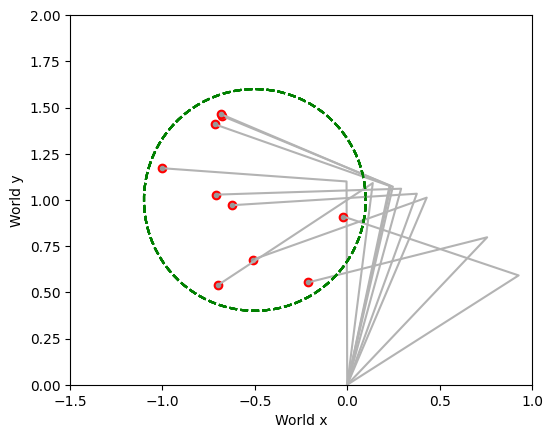

In [274]:
arm = robot.Arm()
target, field, joints = arm.select_points(10)
for k,joint_angs in enumerate(joints):
    arm.draw_target_point(target[k])
    arm.draw(joint_angs)

## How to use the `Population` class
Note that the `Population` class uses PyTorch tensors.

In [275]:
pop = robot.Population(n_neurons=50, radius=1.5, dim=1)
x = torch.linspace(-1.5, 1.5, 200).unsqueeze(1)  # 200 inputs, one per row
A = pop(x)      # Feed inputs into population
print(A.shape)  # should be 200x50

torch.Size([200, 50])


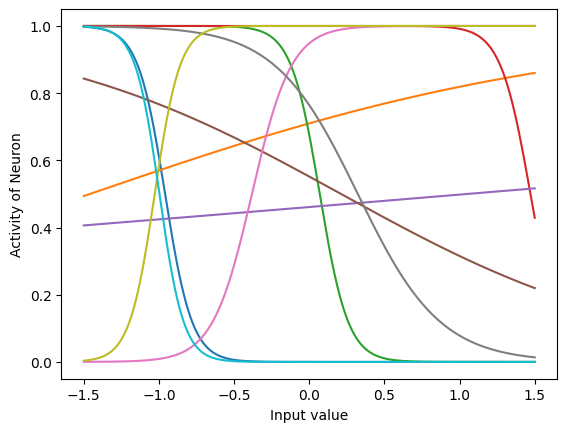

In [276]:
plt.plot(x, A[:,:10]);
plt.xlabel('Input value')
plt.ylabel('Activity of Neuron');

# (a) `Decoding` class
Note that the `Decoding` class uses PyTorch tensors.

In [277]:
class Decoding(torch.nn.Module):
    '''
     dec = Decoding(activities=None, output=None)

     Creates a Decoding object for decoding data neural activities.
     Upon creation, the decoding weights are immediately computed.
     Once this object is created, it can be used like a normal PyTorch Module.

     Inputs:
      input     (P, N) tensor holding activities for N neurons in rows,
                one row for each of the P inputs
      output    (P, dim) tensor holding the corresponding desired outputs

     Usage:
     > pop = Population(n_neurons=50, radius=1.5, dim=3)
     > x = torch.tensor([[1., -0.6, 1.3], [-1.2, 1.4, -0.2]])
     > F = torch.cat((x[:,0]*x[:,1], torch.sin(np.pi*x[:,2])), dim=1)
     > A = pop(x)
     > dec = Decoding(activities=A, output=F)  # Create decoding object
     > y = dec(A)      # Call the decoding object to get its output
     > y.shape
      torch.Size([2, 2])
    '''
    def __init__(self, activities=None, outputs=None):
        super(Decoding, self).__init__()
        assert activities is not None, 'Decoding: You must provide activities'
        assert outputs is not None, 'Decoding: You must provide outputs'

        self.N = activities.shape[1]
        self.out_dim = outputs.shape[1]

        # PyTorch layer that performs the linear decoding
        self.decoder = torch.nn.Linear(self.N, self.out_dim, bias=False)


        #===== Your Code Here =====
        # Compute noise with 1% of max activity as std
        std = 0.01 * torch.max(activities)
        eta = torch.randn_like(activities) * std
        A = activities + eta # Add noise
        A_T = A.T
        # D = torch.inverse(A_T @ A) @ A_T @ outputs
        D = torch.linalg.pinv(A) @ outputs # Weight matrix
        with torch.no_grad():
            self.decoder.weight.data = D.T
        #==========================

    def forward(self, x):

        #===== Your Code Here =====
        return self.decoder(x)
        #==========================


# (b) `ArmController` class
Note that the `ArmController` class uses PyTorch tensors.

In [278]:
class ArmController(torch.nn.Module):
    '''
     brain = ArmController(arm)

     Given an Arm object, creates an ArmController object that can be used to
     control the arm. Its main purpose is to transform the desired target
     location into the corresponding joint angles.
    '''
    def __init__(self, arm):
        super(ArmController, self).__init__()

        #===== Your Code Here =====
        field, world, joints = arm.select_points(5000)

        field = torch.tensor(field, dtype=torch.float32)
        world = torch.tensor(world, dtype=torch.float32)
        joints = torch.tensor(joints, dtype=torch.float32)
        
        # PopA field coordinates to world coordinates
        r_A = 1
        self.popA = robot.Population(n_neurons=500, radius=r_A, dim=2)
        A_activities = self.popA(field)
        self.decodingA = Decoding(A_activities, world)

        # PopB: World(x, y) to joint angles
        max_x = torch.abs(world[:, 0]).max()
        max_y = torch.abs(world[:, 1]).max()
        r_B = max(max_x, max_y).item()
        self.popB = robot.Population(n_neurons=500, radius=r_B, dim=2)
        B_activities = self.popB(world)
        self.decodingB = Decoding(B_activities, joints)
        #==========================

    def forward(self, field):
        # Given a desired point, return the joint angles

        #===== Your Code Here =====
        # Convert input to tensor
        if not isinstance(field, torch.Tensor):
            field = torch.tensor(field, dtype=torch.float32)
        A = self.popA(field)
        world = self.decodingA(A)
        B = self.popB(world)
        joints = self.decodingB(B)
        #==========================
        
        return joints

In [279]:
arm = robot.Arm()
ctrl = ArmController(arm)

# (c) View the arm

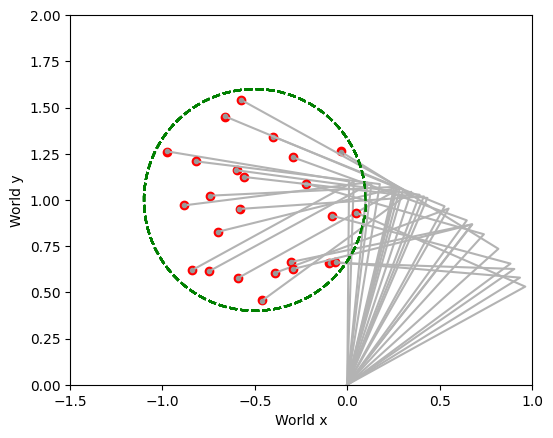

In [280]:
# Draw the reach field
plt.clf()
arm.draw_field()

#===== Your Code Here =====
# Generate 25 random field points
for _ in range(25):
    field, world = arm.random_field_point()
    
    # joint angles
    with torch.no_grad():
        joints = ctrl(field)
    joints = joints.squeeze()

    arm.draw_target_point(field)
    arm.draw(joints)
#==========================

# (d) Reaching Error

In [281]:
err = 0.

#===== Your Code Here =====
# Compute the average Euclidean distance error between the true
# target location and the "finger location" of the robot,
# averaged over 1000 random points.

pw = [] # predicted world
tw = [] # true world
for _ in range(1000):
    field, world = arm.random_field_point()
    tw.append(arm.field2world(field))
    # joint angles
    with torch.no_grad():
        joints = ctrl(field)
    v = arm.finger_location(joints)
    pw.append(v)
    joints = joints.squeeze()
pw = np.array(pw)
diff = pw - tw
# Manually compute the Euclidean distance for each point
errors = np.sqrt(diff[:, 0]**2 + diff[:, 1]**2)

# Average error over all points
avg_err = np.mean(errors)
print(f"Average Euclidean error: {avg_err:.4f}")
#==========================


Average Euclidean error: 0.0019
